# Домашняя работа 2  


Для работы 2 я планирую использовать тот же датасет, что и в предыдущем домашнем задании.  
В результате работы с данными были удалены пропущенные переменные, так как их доля была очень мала, были преобразованы многие переменные: 

   1. Дата рождения была приобразована в Возраст **Age**  
   2. Создана категориальная переменная уровня Дохода **Income**  
   3. Создана категориальная переменная уровня Образования **Education**  
   4. Создана категориальная переменная Семейного положения **Marital_Status**      
   5. Создана бинарная переменная Подверженности промо **Easy_promo**  
   6. Переменная Продаж **Sales** осталась неизменной  
   7. Добавлена переменная логарифма дохода **log_Income**  


Перед началом работы над ДЗ 2, был исправлены ошибки в переменной Easy_promo, в которой некорректно отображались значения ( переменная принемала тоько 0 значения, а должна 1 - если респондент реагировал на промо хотя бы один раз, 0 - в противном случае) 

## Описание данных 
Опишем имеющиеся в нашем финальном датасете переменные  
### Люди 
**Age** - возраст клиента  
**Education** - уровень образования клиента  
**Marital_Status** - семейное положение клиента  
**Income** - годовой доход семьи клиента  
**log_Income** - логарифм годового дохода  
**Kidhome** - бинарная переменная, принимающая *значение 1*, если респондент имеет детей, и *значение 0* в противном случае  
**Teenhome** - бинарная переменная, принимающая *значение 1*, если респондент имеет детей-подростков, и *значение 0* в противном случае   
### Продвижение  
**Easy_promo** - бинарная переменная наличия жалоб, где переменная принимает *значение 1*, если клиент реагировал на промо покупкой хоть раз, и *значение 0* в противном случае  
### Зависимые переменные  
**Sales** - сумма покупок каждого клиента  
**Purchase** - количество продаж на каждого клиента  
## Цель  
Определение зависимости количества покупок и размера потраченных денег, а также восприимчивости людей к промо, от социодемографических показателей клиентов

# Работа с данными 

*Импортируем все необходимые библиотеки*

In [3]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats

*Загрузим наш датасет, скачанный ранее в формате pickle*

In [50]:
df = pd.read_pickle('/Users/dzennetbakueva/Desktop/Все/Учеба/Магистратура /2 курс/data /mark_camp_dz2.pkl')

In [51]:
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Sales,Age,Purchases,Easy_promo,Purchases_Category,log_Income,Income_cat
0,Graduation,Single,58138.0,0,0,1617,65,32,1,High,10.970575,High income
1,Graduation,Single,46344.0,1,1,27,68,11,0,Low,10.743847,High income
2,Graduation,Together,71613.0,0,0,776,57,25,0,Normal,11.179032,High income
3,Graduation,Together,26646.0,1,0,53,38,14,0,Low,10.190394,Middle income
4,PhD,Married,58293.0,1,0,422,41,24,0,Normal,10.973237,High income


*Размер нашей выборки составляет (2216, 12)*

In [52]:
df.shape

(2216, 12)

## Подготовка данных  
#### Переменная *Maritial_Status*

*В датасете имеется переменная Семейного положения. Переведем ее в бинарную для дальнейшей работы и использования при построении моделей*

In [53]:
df['Marital_Status'] = pd.Categorical(df['Marital_Status'])

In [54]:
df['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [55]:
def Martial_Status_Bi(x): 
    if x == 'Together':
        return 1 
    elif x == 'Married':
        return 1 
    else: 
        return 0 
 
df['Martial_Status_Bi'] = df['Marital_Status'].apply(Martial_Status_Bi)

In [56]:
df['Martial_Status_Bi'].sum()

1430

*Проверим корректность нашей переменной, просуммировав количество значений Together и Married в переменной Marital_Status*

In [57]:
print(df[df['Marital_Status'] == 'Together'].value_counts().sum() + df[df['Marital_Status'] == 'Married'].value_counts().sum() )

1430


*Сумма единиц в новой перменной Marital_Status_Bi равна количеству значений Together и Married в переменной Marital_Status, то есть получившаяся новая перемнная корректна*

In [58]:
df['Martial_Status_Bi']  = pd.Categorical(df['Martial_Status_Bi'])

#### Переменная *Sales*

*Создадим бинарную переменную переменную, показывающую, потратил ли клент большое количество денег на свои покупки (1) или нет (0). Для этого определим, что можно считать большой суммой. Предположительно данная сумма должна быть выше медианного значения.*

*Далее получившаяся переменная будет выступать в качестве зависимой для логит модели, показывающей факторы, влияющие на вероятность того, что клиент потратит на покупки большое количество денег*

In [59]:
print('Среднее арифметическое =', df['Sales'].mean())
print('Медиана =', df['Sales'].median())
print('3 квантиль =', np.percentile(df['Sales'], 75))
print('Максимальное значение =', df['Sales'].max() )

Среднее арифметическое = 607.0753610108303
Медиана = 396.5
3 квантиль = 1048.0
Максимальное значение = 2525


*Возьмем значение 1000 как границу высоких затрат на покупки*

In [60]:
df['Sales_Bi'] = df['Sales'].apply(lambda x: 1 if x >= 1000 else 0)
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Sales,Age,Purchases,Easy_promo,Purchases_Category,log_Income,Income_cat,Martial_Status_Bi,Sales_Bi
0,Graduation,Single,58138.0,0,0,1617,65,32,1,High,10.970575,High income,0,1
1,Graduation,Single,46344.0,1,1,27,68,11,0,Low,10.743847,High income,0,0
2,Graduation,Together,71613.0,0,0,776,57,25,0,Normal,11.179032,High income,1,0
3,Graduation,Together,26646.0,1,0,53,38,14,0,Low,10.190394,Middle income,1,0
4,PhD,Married,58293.0,1,0,422,41,24,0,Normal,10.973237,High income,1,0


*Уже в первых 5 наблюдениях видно, что функция работает корректно*

# Регрессионный анализ

*Создадим датасет, содержащий в себя только количественные переменные и найдем матрицу корреляций*

In [61]:
df_col = df.drop(['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'Easy_promo', 'Easy_promo', 'Purchases_Category', 'log_Income', 'Income_cat', 'Martial_Status_Bi', 'Sales_Bi'], axis = 1)

In [62]:
df_col.head()

,Income,Sales,Age,Purchases
0,58138.0,1617,65,32
1,46344.0,27,68,11
2,71613.0,776,57,25
3,26646.0,53,38,14
4,58293.0,422,41,24


*Построим матрицу корреляций и визуализируем это с помощью heatmap*

In [63]:
df_col_mat = df_col.corr()
print(df_col_mat)

             Income     Sales       Age  Purchases
Income     1.000000  0.667576  0.161791   0.412871
Sales      0.667576  1.000000  0.113487   0.630477
Age        0.161791  0.113487  1.000000   0.137848
Purchases  0.412871  0.630477  0.137848   1.000000


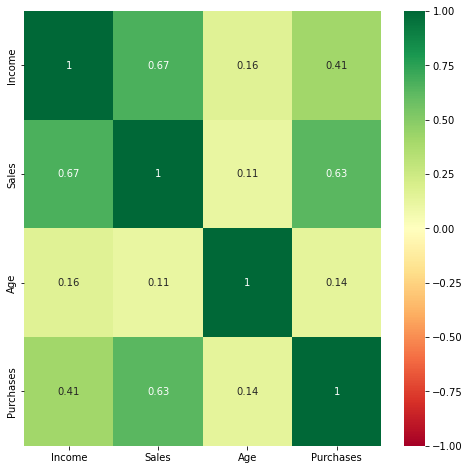

In [64]:
plt.figure(figsize =(8,8))
p=sns.heatmap(df_col.corr(), annot=True, cmap='RdYlGn', vmin=-1, vmax=1 )

*Заметна сильная положительная зависимость между **Доходом** и **Суммой покупок**, а также **Суммой покупок** и **Количеством покупок** (что логичено).*  
Умеренная зависимость между **Доходом** и **Количеством покупок**.  
*Зависимость же между **Возрастом** и всеми другими перменными слабая.*

### Визуализируем данные о наших зависимых переменных Sales и Purchases

Text(0.5, 0.98, 'Зависимость Суммы покупок и Количества покупок от социальных факторов')

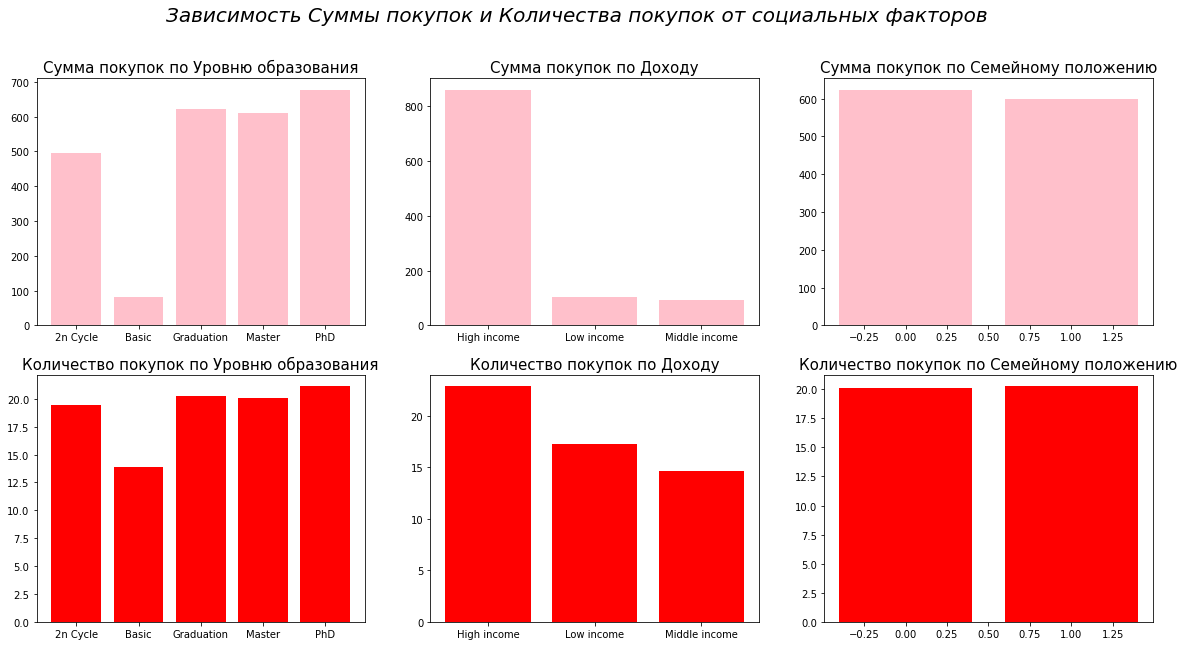

In [325]:
df_ed_sales = df.groupby('Education')['Sales'].mean()
df_ed_purchases = df.groupby('Education')['Purchases'].mean()
df_inc_sales = df.groupby('Income_cat')['Sales'].mean()
df_inc_purchases = df.groupby('Income_cat')['Purchases'].mean()
df_fam_sales = df.groupby('Martial_Status_Bi')['Sales'].mean()
df_fam_purchases = df.groupby('Martial_Status_Bi')['Purchases'].mean()


fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[1][0].bar(df_ed_purchases.index, df_ed_purchases, color='red')
ax[0][0].bar(df_ed_sales.index, df_ed_sales, color='pink')
ax[0][1].bar(df_inc_sales.index, df_inc_sales, color='pink')
ax[0][2].bar(df_fam_sales.index, df_fam_sales, color='pink')
ax[1][1].bar(df_inc_purchases.index, df_inc_purchases, color='red')
ax[1][2].bar(df_fam_purchases.index, df_fam_purchases, color='red')

ax[1][0].set_title('Количество покупок по Уровню образования', fontsize = 15)
ax[0][0].set_title('Сумма покупок по Уровню образования', fontsize = 15)
ax[0][1].set_title('Сумма покупок по Доходу', fontsize = 15)
ax[0][2].set_title('Сумма покупок по Семейному положению', fontsize = 15)
ax[1][1].set_title('Количество покупок по Доходу', fontsize = 15)
ax[1][2].set_title('Количество покупок по Семейному положению', fontsize = 15)

fig.suptitle('Зависимость Суммы покупок и Количества покупок от социальных факторов', fontsize = 20, fontstyle = 'oblique')

## Линейная регрессия зависимости Суммы покупок от социальных факторов 

*Для построения регрессии я создам дполнительные вспомогательные датафреймы, в которых будет содержаться только необходимые переменные*

In [256]:
df_sales_reg = df.drop(['Easy_promo','Education', 'log_Income', 'Marital_Status', 'Purchases_Category', 'Income_cat', 'Sales_Bi', 'Purchases'], axis=1)

*В данном случае мы удаляем в том числе переменные **Количества покупок (Purchases)** и **Easy_promo**, так как между этими переменными может возникнуть мультиколлинеарность. Переменная **Easy_promo** равняется 1 только в том случае, если была совершена покупка, что уже смещает оценку в большую сторону. **Количество же покупок (Purchases)** растет пропорционально сумме потраченных денег на покупки: такая зависимость не несет никакого физического смысла*

In [257]:
df_sales_reg.head()

,Income,Kidhome,Teenhome,Sales,Age,Martial_Status_Bi
0,58138.0,0,0,1617,65,0
1,46344.0,1,1,27,68,0
2,71613.0,0,0,776,57,1
3,26646.0,1,0,53,38,1
4,58293.0,1,0,422,41,1


*Построим линейную регрессию с зависимой перменной **Sales** и описывающими переменными **Income**, **Kidhome**, **Teenhome**, **Age** и **Martial_Status_Bi**.* 

In [258]:
X_mult_1 = sm.add_constant(df_sales_reg.drop('Sales', axis=1))
y_1 = df_sales_reg['Sales']

model = sm.OLS(y_1, X_mult_1)
res_1 = model.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     591.5
Date:                Sat, 10 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:31:42   Log-Likelihood:                -16389.
No. Observations:                2216   AIC:                         3.279e+04
Df Residuals:                    2210   BIC:                         3.282e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               253.5314     48.31

#### Описание результатов модели:

*Переменные **Age** и **Martial_Status_Bi** не являются значимыми переменными при любом уровне значимости, так как гипотеза о равенстве коэффициентов при данных переменных нулю не отвергается*

*Как было видно из графиков выше и видно теперь из регрессионной модели, **Доход (Income)** положительно влияет на сумму покупок и увеличивает ее на **0.0123** с каждой единицей дохода*  

*Переменные **Kidhome** и **Teenhome** же наоборот имеют отрицательное влияние на сумму покупок, уменьшая ее на **434.2331** и **212.9324** единиц соответсвенно*  

*Все остальные переменные модели не являются статистически значимыми*  

*Таким образом, наличие детей и подростков негативно влияют на потраченную сумму покупок. Возможно, причина такого поведения в категориях товаров, которые представлены в данном дата сете (включает в сеюя в трм числе винные продукты и не включает многие товары для детей и подростков)*

#### Проверка качества модели:

*Коэффициент детерминации **R2 = 0.572**. Это говорит о том, что полученная модель объясняет 61% дисперсии зависимой переменной. Даннная модель может считаться качественной, однако необходимо проверить показатели **MSE**, **MAE** и **RMSE**.*

In [260]:
features_1 = df_sales_reg.drop('Sales', axis=1)
y_1 = df_sales_reg['Sales']

In [261]:
y_true_1 = y_1

In [ ]:
from sklearn.linear_model import LinearRegression
reg_1 = LinearRegression().fit(features_1, y_1)

In [263]:
y_pred_1 = reg_1.predict(features_1)

Text(0, 0.5, 'Predicted values')

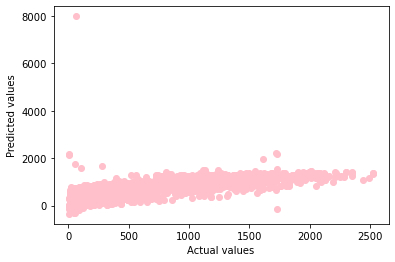

In [264]:
plt.scatter(y_1, y_pred_1, color = 'pink')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

In [328]:
err_1 = y_1 - y_pred_1
err_d_1 = pd.DataFrame(data = err_1)

array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

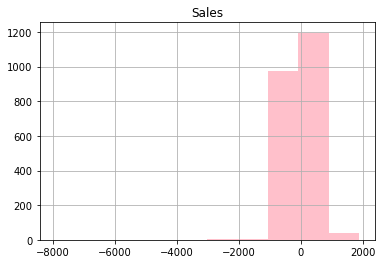

In [267]:
err_d_1.hist(color='pink')

In [268]:
from sklearn.metrics import mean_absolute_error
print('MAE = %s' % mean_absolute_error(reg_1.predict(features_1),y_1))
print('MSE =', mean_squared_error(y_true_1, y_pred_1))
print('RMSE = %s' % mean_squared_error(reg_1.predict(features_1),y_1))
print('R-squared =', r2_score(y_1, y_pred_1))

MAE = 267.87859331029415
MSE = 155377.90538246118
RMSE = 155377.90538246118
R-squared = 0.5723445273489021


*Мы имеем очень высокие показатели **MAE** (среднее отклонение реального значения от предсказанного), **MSE** (квадрат отклонения ожидаемой оценки от реальной) и **RMSE** (корень MSE). Это говорит о том, что модель не точная, несмотря на высокий коэффициент детерминации. Большое значение **RMSE** может быть связано стем, что в данных есть выбросы*  

*Однако мы все еще имеем высокий коэффициент детерминации и можем предположить, что при тех же исходных, но без выбросов, данная модель может быть достаточно качественной*

## Линейная регрессия зависимости Количества покупок от социальных факторов 

*Построим линейную регрессию с зависимой перменной **Purchases** и описывающими переменными **Income**, **Kidhome**, **Teenhome**, **Age** и **Martial_Status_Bi**.*

In [244]:
df_purch_reg = df.drop(['Education', 'log_Income', 'Marital_Status', 'Purchases_Category', 'Income_cat', 'Sales_Bi', 'Sales', 'Easy_promo'], axis=1)

In [311]:
X_mult_2 = sm.add_constant(df_purch_reg.drop('Purchases', axis=1))
y_2 = df_purch_reg['Purchases']

model = sm.OLS(y_2, X_mult_2)
res_2 = model.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:              Purchases   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     141.3
Date:                Sun, 11 Dec 2022   Prob (F-statistic):          2.64e-130
Time:                        23:01:25   Log-Likelihood:                -7236.6
No. Observations:                2216   AIC:                         1.449e+04
Df Residuals:                    2210   BIC:                         1.452e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                16.6644      0.77

#### Описание результатов модели: 

*Переменные **Age** и **Martial_Status_Bi** не являются значимыми переменными, так как в результате t-тестирования вероятность нулевого коэффициента при данных переменных не близка к 0. Так же в доверительный интервал входит 0, что так же говорит нам о статистической незначимости перемнных*

*Результаты данной модели несколько отличаются от модели с зависимой перменной **Суммы покупок (Sales)**. В данной моделе **Доход (Income)** также имеет положительное влияние, хоть и незначительное, на количество покупок клиента, увеличивая количество покупок на **9.129e-05**.*  

*Наличие детей **(Kidhome)** же уменьшает количество покупок на **3.3356**. Это можно объяснить тем, что совершать покупки с детьми легче разово, чем дробить на несколько сессий (однако, это лишь предположение)*  

*Переменная наличия подростков домат **(Teenhome)** увеличивает колчиество покупок на **2.6434**, что также можно попробовать объяснить некоторой самостоятельностью подростков в совершении покупок (так как подсчет покупок идет на домохозяйство).*

#### Проверка качества модели:

*Коэффициент детерминации **R2 = 0.242**. Это говорит о том, что полученная модель объясняет 27% дисперсии зависимой переменной. Это достаточно низкое значение, что говорит о том, что полученная модель некачественна. В связи с этимданная модель не будет рассмотрена подробно. Yеобходимо проверить показатели **MSE**, **MAE** и **RMSE**.*

In [247]:
features_2 = df_purch_reg.drop('Purchases', axis=1)
y_2 = df_purch_reg['Purchases']

In [248]:
y_true_2 = y_2

In [ ]:
from sklearn.linear_model import LinearRegression
reg_2 = LinearRegression().fit(features_2, y_2)

In [327]:
y_pred_2 = reg_2.predict(features_2)

Text(0, 0.5, 'Predicted values')

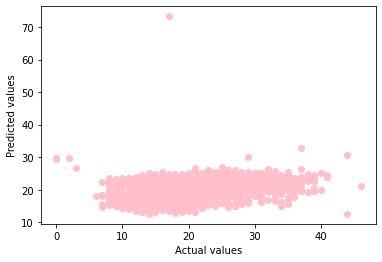

In [304]:
plt.scatter(y_2, y_pred_2, color = 'pink')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

In [306]:
err_2 = y_2 - y_pred_2

err_d_2 = pd.DataFrame(data = err_2)

array([[<AxesSubplot:title={'center':'Purchases'}>]], dtype=object)

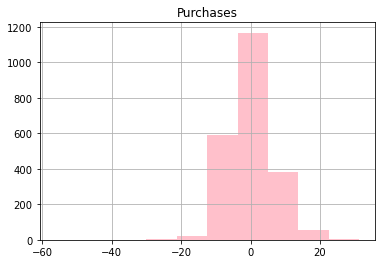

In [307]:
err_d_2.hist(color='pink')

In [309]:
from sklearn.metrics import mean_absolute_error
print('MAE = %s' % mean_absolute_error(reg_2.predict(features_2),y_2))
print('MSE =', mean_squared_error(y_true_2, y_pred_2))
print('RMSE = %s' % mean_squared_error(reg_2.predict(features_2),y_2))
print('R-squared =', r2_score(y_2, y_pred_2))

MAE = 4.881145970430491
MSE = 40.178783941853155
RMSE = 40.178783941853155
R-squared = 0.24220937408761545


*В данном случае у нас все показатели довольно низкие, включая R-squared, однако низкие показатели всех остальных показателей говорят о точности данной модели* 

## Логистическая модели Вероятности совершения покупки с высоким чеком от социальных факторов.

*Построим логистическую модель с зависимой перменной **Sales_Bi** и описывающими переменными **Income**, **Kidhome**, **Teenhome**, **Age**, **Easy_promo** и **Martial_Status_Bi**. В данном случае зависимой переменной выступает бинарная перменная со значениями 1 (большая сумма покупок) и 0 (маленькая сумма покупок)*

In [269]:
df_sales_bi_reg = df.drop(['Easy_promo', 'Education', 'log_Income', 'Marital_Status', 'Purchases_Category', 'Income_cat', 'Sales', 'Purchases'], axis=1)

In [270]:
X_l_1 = sm.add_constant(df_sales_bi_reg.drop('Sales_Bi', axis=1))
y = df_sales_bi_reg['Sales_Bi']

logit = sm.Logit(y, X_l_1)
results_log_1 = logit.fit()
print(results_log_1.summary())

Optimization terminated successfully.
         Current function value: 0.314415
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               Sales_Bi   No. Observations:                 2216
Model:                          Logit   Df Residuals:                     2210
Method:                           MLE   Df Model:                            5
Date:                Sat, 10 Dec 2022   Pseudo R-squ.:                  0.4608
Time:                        18:32:40   Log-Likelihood:                -696.74
converged:                       True   LL-Null:                       -1292.2
Covariance Type:            nonrobust   LLR p-value:                2.780e-255
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.0144      0.479    -10.472      0.000      -5.953      -4.076
Income  

#### Описание результатов модели:

 *Для того, чтобы понять влияние коэффициентов при независимых переменных на зависимую, необхомо взять экспаненту от значений коэффициента. Ниже представлено уравнение логичстической модели, из которого видно, что отношение вероятностей равно экспоненте от правой стороны уравнения*

$$
y = ln(Odds) = ln(\frac{p}{1 - p}) = \beta_0 + \beta_1 \cdot x_1 + ... + = \beta_k \cdot x_k 
$$  
Примечание: Формула взята из записей к семинару по Логистическим моделям

*Переменные **Age** и **Martial_Status_Bi** не являются значимыми переменными при любых уровнях значимости*

In [322]:
print('ln(const) =', np.exp(-5.0144).round(3))
print('ln(Income) =', np.exp(8.984e-05).round(3))
print('ln(Kidhome) =', np.exp(-1.7450).round(3))
print('ln(Teenhome) =', np.exp(-0.9725).round(3))

ln(const) = 0.007
ln(Income) = 1.0
ln(Kidhome) = 0.175
ln(Teenhome) = 0.378


*Переменная **Income** практически не влияет на сумму трат*  

*Переменная **Kidhome** уменьшает зависимую переменную больше, чем в **5 раз** при наличии детей дома*  

*Переменная **Teenhome** уменьшает зависимую переменную больше, чем в **2.5 раза** при наличии подростков дома*  

*В данном случае коэффициент детерминации не будет являться показательным для модели логит.*

*То есть подверженность промо имеет наибольшее положительное влияние на совершение больших покупок*

#### Проверка качества модели:

*Для проверки качества данной логистической модели, определим точность модели (долю правильных ответов)*  

$$
accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

In [330]:
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

In [371]:
X_log_reg_1 = df_sales_bi_reg[['Income', 'Kidhome', 'Teenhome', 'Age', 'Martial_Status_Bi']]

In [372]:
y_log_1 = df_sales_bi_reg.Sales_Bi.values

In [373]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_log_reg_1 , y_log_1, test_size = 0.2, random_state=10)

In [374]:
X_reg_train_1, X_reg_valid_1, y_reg_train_1, y_reg_valid_1 = train_test_split(X_log_reg_1, y_log_1, test_size = 0.2, random_state=10)

In [375]:
z_score_scaler = StandardScaler() 

z_score_scaler.fit(X_train_1)

StandardScaler()

In [376]:
X_train_scaled_1 = z_score_scaler.transform(X_train_1)
X_valid_scaled_1 = z_score_scaler.transform(X_valid_1)

In [377]:
z_score_reg_scaler_1 = StandardScaler()
z_score_reg_scaler_1.fit(X_reg_train_1)

X_train_reg_scaled_1 = z_score_reg_scaler_1.transform(X_reg_train_1)
X_valid_reg_scaled_1 = z_score_reg_scaler_1.transform(X_reg_valid_1)

In [378]:
Log_reg_model_1 = LogisticRegression()

Log_reg_dummy_model_1 = LogisticRegression()

Log_reg_model_1.fit(X_train_scaled_1, y_train_1)

Log_reg_dummy_model_1.fit(X_train_reg_scaled_1, y_reg_train_1)

LogisticRegression()

In [379]:
y_pred_1 = Log_reg_model_1.predict(X_valid_scaled_1)
y_pred_probs_1 = Log_reg_model_1.predict_proba(X_valid_scaled_1)

In [380]:
y_pred_dummy_1 = Log_reg_dummy_model_1.predict(X_valid_reg_scaled_1)
y_pred_probs_dummy_1 = Log_reg_dummy_model_1.predict_proba(X_valid_reg_scaled_1)

In [381]:
from sklearn.metrics import accuracy_score, f1_score,\
recall_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve

accuracy_score(y_valid_1, y_pred_1)
print('Accuracy :', accuracy_score(y_valid_1, y_pred_1).round(3))

Accuracy : 0.874


*Доля правильных ответов достаточно высокая (87%), что говорит о качестве модели.*

## Логистическая модели Вероятности совершения покупки после просмотра промо от социальных факторов.

*Как объяснялось ранее из датафрейма удаляются пермеенные, которые могут сместить оценку и снизить ее эффективность  (так как между переменными будет мультиколлинеарность)*

In [285]:
df_promo_reg = df.drop(['Sales', 'Education', 'Marital_Status', 'Purchases_Category', 'Income_cat', 'Sales_Bi', 'Purchases', 'log_Income'], axis=1)

*Построим логистическую модель с зависимой перменной **Easy_promo** (1 - клиент совершил покупку после просмотра одного из промо, 0 - в противном случае) и описывающими переменными **Income**, **Kidhome**, **Teenhome**, **Age** и **Martial_Status_Bi**.*

In [290]:
X_l_2 = sm.add_constant(df_promo_reg.drop('Easy_promo', axis=1))
y_l_2 = df_promo_reg['Easy_promo']

logit = sm.Logit(y_l_2, X_l_2)
results_log_2 = logit.fit()
print(results_log_2.summary())

Optimization terminated successfully.
         Current function value: 0.541864
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Easy_promo   No. Observations:                 2216
Model:                          Logit   Df Residuals:                     2210
Method:                           MLE   Df Model:                            5
Date:                Sun, 11 Dec 2022   Pseudo R-squ.:                 0.07569
Time:                        22:21:01   Log-Likelihood:                -1200.8
converged:                       True   LL-Null:                       -1299.1
Covariance Type:            nonrobust   LLR p-value:                 1.480e-40
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.9486      0.302     -6.448      0.000      -2.541      -1.356
Income  

#### Описание результатов модели:

*Так как коэффициенты при независимых переменных - это логарифм отношения вероятностей, то чтобы узнать влияние факторов на зависимую переменную, необходимо взять экспоненту от значений коэффициентов*

*Переменные **Age** и **Kidhome** не являются значимыми переменными при любых уровнях значимости*

In [323]:
print('exp(const) =', np.exp(-1.9486).round(3))
print('exp(Income) =', np.exp(2.323e-05).round(3))
print('exp(Teenhome) =', np.exp(-0.6711).round(3))
print('exp(Martial_Status_Bi) =', np.exp(-0.2899).round(3))

exp(const) = 0.142
exp(Income) = 1.0
exp(Teenhome) = 0.511
exp(Martial_Status_Bi) = 0.748


*Как и в предыдущих моделях, Доход **(Income)** хоть и влияет положительно на зависимую переменную, но имеет довольно слабое влияние*  

*Наличие детей **(Kidhome)** и подростков **(Teenhome)** у клиентов же имеют горахдо большее влияние, снижая вероятность того, что клиент будет восприимчив к промо в **2 раза и 1.5 раза соответсвенно**.*

#### Проверка качества модели:

*Для проверки качества данной логистической модели, определим точность модели (долю правильных ответов)*  

$$
accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

In [353]:
X_log_reg_2 = df_promo_reg[['Income', 'Kidhome', 'Teenhome', 'Age', 'Martial_Status_Bi']]

In [354]:
y_log_2 = df_promo_reg.Easy_promo.values

In [356]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_log_reg_2 , y_log_2, test_size = 0.2, random_state=10)

In [357]:
X_reg_train_2, X_reg_valid_2, y_reg_train_2, y_reg_valid_2 = train_test_split(X_log_reg_2, y_log_2, test_size = 0.2, random_state=10)

In [358]:
z_score_scaler = StandardScaler() 

z_score_scaler.fit(X_train_2)

StandardScaler()

In [361]:
X_train_scaled_2 = z_score_scaler.transform(X_train_2)
X_valid_scaled_2 = z_score_scaler.transform(X_valid_2)

In [359]:
z_score_reg_scaler_2 = StandardScaler()
z_score_reg_scaler_2.fit(X_reg_train_2)

X_train_reg_scaled_2 = z_score_reg_scaler_2.transform(X_reg_train_2)
X_valid_reg_scaled_2 = z_score_reg_scaler_2.transform(X_reg_valid_2)

In [362]:
Log_reg_model_2 = LogisticRegression()

Log_reg_dummy_model_2 = LogisticRegression()

Log_reg_model_2.fit(X_train_scaled_2, y_train_2)

Log_reg_dummy_model_2.fit(X_train_reg_scaled_2, y_reg_train_2)

LogisticRegression()

In [363]:
y_pred_2 = Log_reg_model_2.predict(X_valid_scaled_2)
y_pred_probs_2 = Log_reg_model_2.predict_proba(X_valid_scaled_2)

In [364]:
y_pred_dummy_2 = Log_reg_dummy_model_2.predict(X_valid_reg_scaled_2)
y_pred_probs_dummy_2 = Log_reg_dummy_model_2.predict_proba(X_valid_reg_scaled_2)

In [369]:
from sklearn.metrics import accuracy_score, f1_score,\
recall_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve

accuracy_score(y_valid_2, y_pred_2)
print('Accuracy :', accuracy_score(y_valid_2, y_pred_2).round(3))

Accuracy : 0.752


*Точность данной модели ниже, чем в предыдущей, и составляет 75%. Однако данный показатель все еще высокий*

# Выводы:

*Из всех получившихся моделей можно сделать вывод, что возраст **(Age)** клиента **не влияент ни на сумму и количество покупок, ни на восприимчивость к промоакциям**.*  

*Наличие же партнера у клиента **(Martial_Status_Bi)** имеет статистическую значимость лишь в логистической модели восприимчивости клиента к промоакциям, где наличие партнера **снижает вероятность того, что клиент совершит покупку после просмотра промо**.*  

*Для всех моделей характерно **увеличение зависимой переменной при увеличении Дохода**. Однако во всех моделях Доход имеет малое влияние.*  

*Наличие детей **(Kidhome)** и подростков **(Teenhome)** в домохозяйстве **негативно сказывается почти на все зависимые перемнные** кроме количества покупок, где наличие подростков увеличивает число покупок.*  

*Таким образом, на основе данного исследования, можно построить партрет **идеального клиента** в глазах производителей: **человек любого возраста (от 18 лет) без детей (в том числе и подростков) и без партнера**. Дети и подростки снижают средний чек для рассматриваемых производителей, партнер же у клиента снижает восприимчивость к промоакциям (что является одной из важных характеристик идеального клиента).* 